In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from molsim import mullerBrownPotential, mullerBrownPotentialAndGradient, plot_muller_brown_heatmap

# Exercise 1: Barrier crossing

Consider the movement of a single particle that moves on a 1D potential energy surface
with the following functional form:

\begin{equation}
U(x) =
\begin{cases}
2\epsilon B x^2, & 0 < x \\
\epsilon (1 - \cos(2\pi x)), & 1 > x \geq 0 \\
2\epsilon B (x - 1)^2, & x \geq 1
\end{cases}
\end{equation}

The energy, force and the derivative of the force are continuous functions of the position x. Please first determine the value of B. 
What is the energy barrier of these potential energy at different value of $\epsilon$?


## Answer
$B = \pi^2$. Computing the derivative of the force (negative derivative of energy) of the first case we get:
$$
\frac{d^2 U}{dx^2} = -4\epsilon B \quad \forall x>0 
$$
Computing the derivative of the force of the second case we get:
$$
\frac{d^2 U}{dx^2} = -4\pi^2\epsilon\cos{(2\pi x)} \quad \forall 1 > x \geq 0
$$

Since we know the second derivative must be continuous, we can take the limit of these sequences as they approach $x =
0$ and equate them to each other:
$$
\begin{align*}
4\epsilon B = 4\pi^2\epsilon
\end{align*}
$$
$$
\boxed{B=\pi^2}
$$
___
The energy barrier that these particles must cross can be computed as $\boxed{U_{barrier} = \epsilon(1-\cos{(\pi)}) =
2\epsilon}$  
If they are at 0 or 1 they must get atleast this much energy to cross the hump

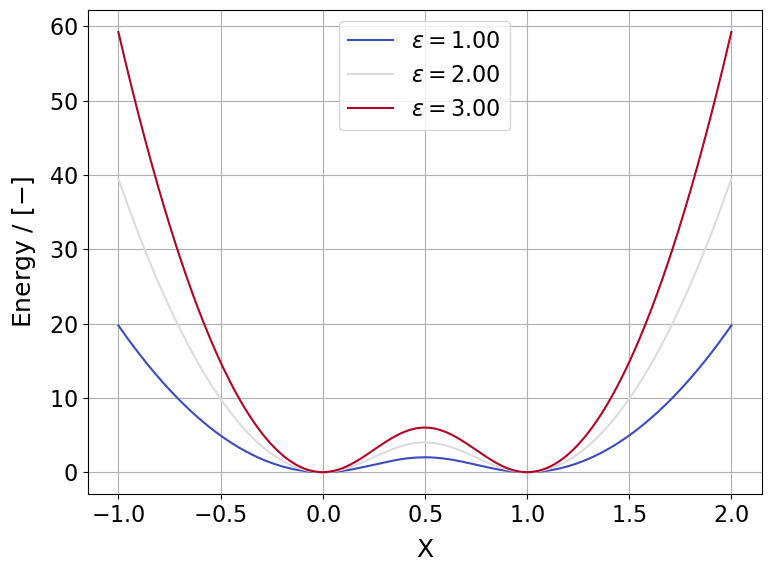

In [5]:
fig, ax = plt.subplots()
x = np.linspace(-1, 2, 1000)
e_range = [1 ,2 , 3]
cmap = plt.cm.coolwarm(np.linspace(0, 1, len(e_range)))

# start implementation

def U(x,e):
    B = np.pi**2
    if x < 0:
        return 2 * e * B * (x**2)
    elif x >= 0 and x < 1:
        return e * (1 - np.cos(2 * np.pi * x))
    else: 
        return 2 * e * B * (1 - x)**2

# end implementation

U_vec = np.vectorize(U)
for i, e in enumerate(e_range):
    ax.plot(x, U_vec(x, e), label=r"$\epsilon=$" + f"{e:4.2f} ", c=cmap[i])

ax.set_xlabel("X")
ax.set_ylabel(r"Energy / $[-]$")
ax.legend()
plt.show()

## Question2

A program is provided that integrates the equation of motion of the particle starting at x (t = 0) = 0 using several methods at extremly low temperature(T = 0.05 and $\epsilon$ = 1). What do you expect the phase space trajectories (v-x figure) to look like in the following situations.



In [11]:
# start implementation
def U(x):
    e = 1
    B = np.pi**2
    if x < 0:
        return 2 * e * B * (x**2)
    elif x >= 0 and x < 1:
        return e * (1 - np.cos(2 * np.pi * x))
    else: 
        return 2 * e * B * (1 - x)**2

def force(x):
    e = 1
    B = np.pi**2

    if x < 0:
        return -4 * e * B * x
    elif x >= 0 and x < 1:
        return -2 * np.pi * e * np.sin(2 * np.pi * x)
    else: 
        return -4 * e * B * (1 - x)

# end implementation

(a) No thermostat (NVE ensemble).

## Answer
I expect it to be in a circle. As the particle oscillates back and forth over the hump in the energy field


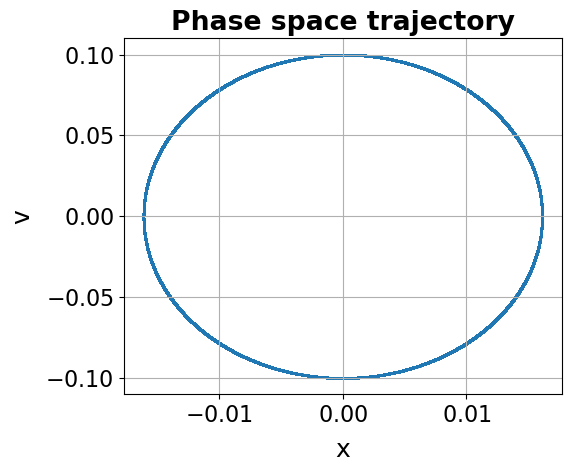

In [ ]:
dt = 0.05    
steps = 100000  
mass = 1.0 
##initial position and v
x = 0.0 
v = 0.1

trajectory = []
velocity = []
energies = []
F = force(x)

##Velocity Verlet
for step in range(steps):
# start implementation
    force_calc = (F / mass) * (dt / 2.0)
    v_half_step = v + force_calc
    x = x + v_half_step * dt
    F_new = force(x)
    v = v_half_step + (F_new / mass) * (dt / 2.0)
    F = F_new

# end implementation
    trajectory.append(x.copy())
    velocity.append(v)
    kinetic = 0.5 * mass * np.sum(v**2)
    potential = U(x)
    energies.append((kinetic, potential, kinetic + potential))

plt.figure(figsize=(6, 5))
plt.scatter(trajectory, velocity, s=1)
plt.xlabel('x')
plt.ylabel('v')
plt.title('Phase space trajectory')
plt.tight_layout()
plt.show()



(b)The Andersen thermostat. In this method, the velocity of the particle is coupled to a stochastic heat bath which leads to a canonical distribution.

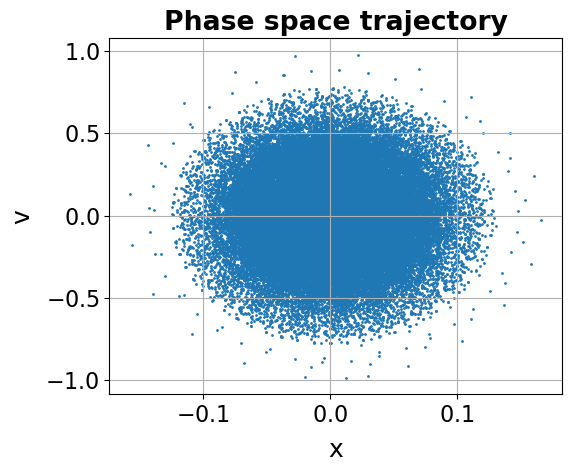

In [15]:
dt = 0.05            
steps = 100000         
mass = 1.0     

#Thermostate parameters
T = 0.05              
nu = 1.0              #Andersen collision frequency
kB = 1.0   


def sample_velocity(T): 
    sigma = np.sqrt(kB * T / mass)
    return np.random.normal(0.0, sigma)

##initial position and v          
x = 0.0     
v = 0.1   

trajectory = []
velocity = []
energies = []
F = force(x)

##Velocity Verlet
for step in range(steps):
    # start implementation
    force_calc = (F / mass) * (dt / 2.0)
    v_half_step = v + force_calc
    x = x + v_half_step * dt
    F_new = force(x)
    v = v_half_step + (F_new / mass) * (dt / 2.0)
    F = F_new
    
## Andersen Thermostat: 
    if np.random.rand() < nu * dt:
        v = sample_velocity(T)
    # end implementation
        
    trajectory.append(x.copy())
    velocity.append(v)
    kinetic = 0.5 * mass * np.sum(v**2)
    potential = U(x)
    energies.append((kinetic, potential, kinetic + potential))


plt.figure(figsize=(6, 5))
plt.scatter(trajectory, velocity, s=1)
plt.xlabel('x')
plt.ylabel('v')
plt.title('Phase space trajectory')
plt.tight_layout()
plt.show()


(c) A Nosé-Hoover chain(chaine length = 2). In this method, the motion of the particle is coupled to a chain of thermostats. The equations of motion are integrated using an ex-
plicit time-reversible algorithm. One can prove that this method yields a canonical distribution provided that the system is ergodic.

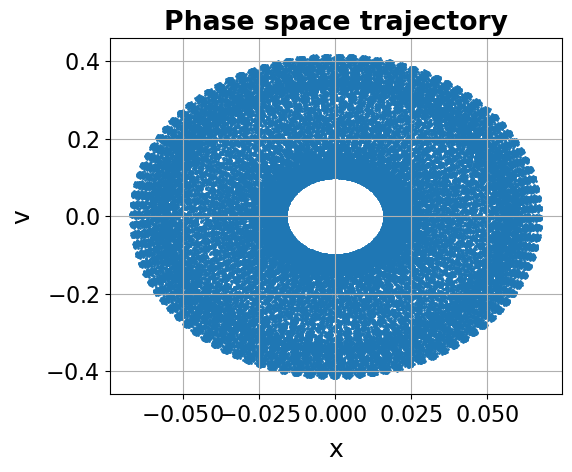

In [17]:
dt = 0.05
n_steps = 100000
mass = 1.0

kB = 1.0
T = 0.05
Q1 = 1.0
Q2 = 1.0

x = 0.0
v = 0.1
xi1 = 0.0
xi2 = 0.0

trajectory = []
velocities = []
xis1 = []
xis2 = []
energies = []
N_f = 1

for step in range(n_steps):
# start implementation
 # --- Step 1: Update outermost thermostat momentum p_eta2 (xi2) by dt/2 ---
    # Force G_xi2 = (p_eta1^2/Q1 - kB*T)
    G_xi2 = (xi1**2 / Q1 - kB * T)
    xi2_half_step = xi2 + G_xi2 * dt / 2.0

    # --- Step 2: Update inner thermostat momentum p_eta1 (xi1) by dt/2 ---
    # This involves its "force" G_xi1 and damping from p_eta2_half_step
    # G_xi1 = (particle_KE_sum - N_f*kB*T) = (mass*v^2 - N_f*kB*T)
    exp_factor_xi1_damping = np.exp(-(xi2_half_step / Q2) * dt / 2.0)
    
    xi1 = xi1 * exp_factor_xi1_damping
    G_xi1_undamped = (mass * v**2 - N_f * kB * T) # Using current v
    xi1 = xi1 + G_xi1_undamped * dt / 2.0
    xi1 = xi1 * exp_factor_xi1_damping # xi1 is now effectively xi1(t+dt/2)

    # --- Step 3: Update particle velocity v by dt/2 ---
    # This involves its physical force F(x) and damping from p_eta1_half_step
    exp_factor_v_damping = np.exp(-(xi1 / Q1) * dt / 2.0) # Using xi1(t+dt/2)
    
    v = v * exp_factor_v_damping
    F_current = force(x) # Physical force at x(t)
    v = v + (F_current / mass) * dt / 2.0 # v is now effectively v_intermediate or v_at_half_force_kick

    # --- Step 4: Update particle position x by full dt ---
    # Using v_intermediate which acts like v(t+dt/2) for position update
    x = x + v * dt # x is now x(t+dt)

    # --- Step 5: Update particle velocity v for the second dt/2 ---
    # Physical force at x(t+dt), then second half of damping from p_eta1_half_step
    F_new = force(x) # Physical force at x(t+dt)
    v = v + (F_new / mass) * dt / 2.0
    v = v * exp_factor_v_damping # Apply second half of damping using the same exp_factor_v_damping for symmetry

    # --- Step 6: Update inner thermostat momentum p_eta1 (xi1) for the second dt/2 ---
    # Uses updated particle velocity v(t+dt)
    # Damping from p_eta2_half_step (same as in step 2 for symmetry)
    xi1 = xi1 * exp_factor_xi1_damping
    G_xi1_undamped_new = (mass * v**2 - N_f * kB * T) # Using v(t+dt)
    xi1 = xi1 + G_xi1_undamped_new * dt / 2.0
    xi1 = xi1 * exp_factor_xi1_damping # xi1 is now xi1(t+dt)

    # --- Step 7: Update outermost thermostat momentum p_eta2 (xi2) for the second dt/2 ---
    # Uses updated p_eta1(t+dt)
    G_xi2_new = (xi1**2 / Q1 - kB * T)
    xi2 = xi2_half_step + G_xi2_new * dt / 2.0 # Update from xi2_half_step to get xi2(t+dt)


# end implementation
    trajectory.append(x)
    velocities.append(v)
    xis1.append(xi1)
    xis2.append(xi2)
    kinetic = 0.5 * mass * v**2
    potential = U(x)
    energy = kinetic + potential + 0.5 * Q1 * xi1**2 + 0.5 * Q2 * xi2**2
    energies.append(energy)
    
plt.figure(figsize=(6, 5))
plt.scatter(trajectory, velocities, s=1)
plt.xlabel('x')
plt.ylabel('v')
plt.title('Phase space trajectory')
plt.tight_layout()
plt.show()

(d) No molecular dynamics, but a simple Monte Carlo scheme.

Accept rate: 0.02697


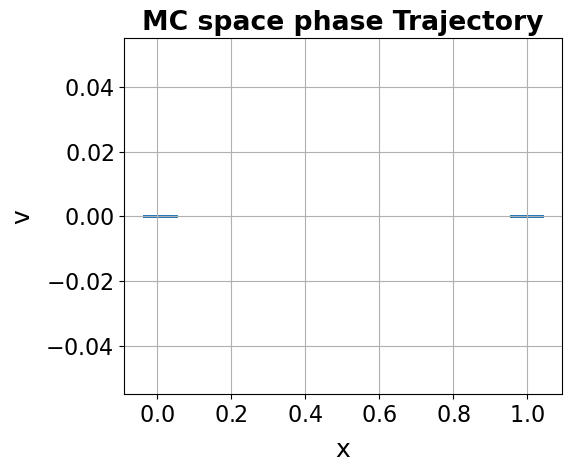

In [25]:
n_steps = 100000
T = 0.005                    
kB = 1.0                     
beta = 1 / (kB * T)
delta = 1.0                 

x = 0.0
energy = U(x)

positions = []
energies = []

accept_count = 0

# start implementation
for step in range(n_steps):
    trial_pos = x + np.random.uniform(-delta, delta)
    trial_energy = U(trial_pos)
    dE = trial_energy - energy

    if np.random.rand() < np.exp(-beta * dE):
        x = trial_pos
        energy = trial_energy
# end implementation
        accept_count += 1

    positions.append(x)
    energies.append(energy)


positions = np.array(positions)
energies = np.array(energies)
velocity = np.zeros(n_steps)
accept_rate = accept_count/n_steps
print(f"Accept rate: {accept_rate}")

plt.figure(figsize=(6, 5))
plt.scatter(positions, velocity, s=1)
plt.xlabel('x')
plt.ylabel('v')
plt.title('MC space phase Trajectory')
plt.show()



## Question 3:

(a) Why does the phase space distribution of the MC scheme look so much different at low temperatures ?

(b) Why does the phase space distribution of the NVE scheme look like a circle ?

(c) How long has the Nosé-Hoover chain to be to obtain a canonical distribution ?


## Answer
(a) At low temperatures the $\beta$ value will be large meaning that $exp(-\beta * dE)$ will be small so we reject a lot
more configurations and so only small moves from the particle starting locations are accepted. Also since we choose a
point at random to move and then check to see if the movement is "valid", there is no concept of a "velocity" and hence
the phase space distribution is flat. Also, unlike molecular dynamic methods where particles have kinetic energy which
would allow them to surmount the barrier, the MC method explores the configuration space via trial moves, which either
get accepted or do not. So for low temperatures we tend to see this clustering around the initial starting point.

(b) This comes from the fact that the total energy of the system is conserved. The total energy can be written as:
$$
\begin{align*}
    E &= U_{K}(v) + U_{P}(x) \\
    E &= \frac{1}{2}mv^2 + U_{P}(x)
\end{align*}
$$
Since our systems seems to oscillate in the $0\leq x \leq 1$ we will focus our analysis of the potential energy in that
region:
$$
\begin{align*}
    E &= \frac{1}{2}mv^2 + \epsilon(1- \cos{(2\pi x)})
\end{align*}
$$

Lets then perform a Taylor expansion of the cosine term in the potential energy:
$$
\begin{align*}
    E &= \frac{1}{2}mv^2 + \epsilon(1 - 1 + \frac{4\pi^2x^2}{2} - \mathcal{O}(x^4))\\
    E &= \frac{1}{2}mv^2 + 2\pi^2x^2\epsilon - \epsilon\mathcal{O}(x^4)
\end{align*}
$$

We can assume that the $\mathcal{O}(x^4)$ is small and so we can drop it from the eq. So we are finally left with:
$$
\boxed{E = \frac{1}{2}mv^2 + 2\pi^2x^2\epsilon}
$$
Since the energy of the system must stay constant, this must trace a circle in the phase space of $(v, x)$. 

(c) One requirement for a thermostat to generate a canonical distribution is that the extended system (the one including
the thermostat variables) must be ergodic. Sometimes it is possible that the thermostat variables could oscillate
predictably and so would not act as a random heat bath and therefore the simulation would not generate a canonical
distribution. However, we can make use of chaining where we create a second thermostat to thermostat the first one
(which is thermostat-ing our physical system). In this way we can ensure that the chain would act as a proper random
heat bath. For some systems a chain of 1 is enough, however chains of 2-4 are commonly used in practice.    

## Question 4:

Investigate at which temperature the particle is able to cross the energy barrier using the above method.


## Student Comment
Which method are you referring to? I assumed that it was the MC method. 

Jumped the barrier!
Accept rate: 1e-05


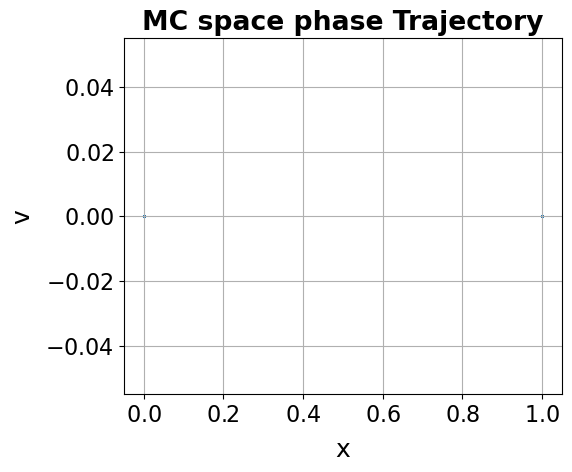

In [43]:
n_steps = 100000
T = 0.0000000003
kB = 1.0                     
beta = 1 / (kB * T)
delta = 1.0                 

x = 0.0
energy = U(x)

positions = []
energies = []

accept_count = 0

# start implementation
for step in range(n_steps):
    trial_pos = x + np.random.uniform(-delta, delta)
    trial_energy = U(trial_pos)
    dE = trial_energy - energy

    if np.random.rand() < np.exp(-beta * dE):
        if (x < 0.5 and trial_pos >= 0.5) or (x >= 0.5 and trial_pos < 0.5):
            print("Jumped the barrier!")
        x = trial_pos
        energy = trial_energy
# end implementation
        accept_count += 1

    positions.append(x)
    energies.append(energy)


positions = np.array(positions)
energies = np.array(energies)
velocity = np.zeros(n_steps)
accept_rate = accept_count/n_steps
print(f"Accept rate: {accept_rate}")

plt.figure(figsize=(6, 5))
plt.scatter(positions, velocity, s=1)
plt.xlabel('x')
plt.ylabel('v')
plt.title('MC space phase Trajectory')
plt.show()



## Question 4 Answer

I noticed that particles started to jump the barrier at $T=3 \times 10^{-10}$